In [1]:
import sys
sys.path.append('../Codes/library/')
sys.path.append('../Codes/Python/')
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
from Immuno_models import*
#from Bio import Phylo
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special as sc
import os.path
import pickle
from matplotlib import style
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from IPython.display import display, Math
import json

Text_files_path = '/Users/robertomorantovar/Dropbox/Research/Evolution_Immune_System/Text_files/'

N_A = 6.02214076e23
k_BT = 1.380649e-23*293
style.use('seaborn-paper')
print(style.available)
%autosave 60

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


Autosaving every 60 seconds


## Plotting Matrices

In [5]:
M1 = np.loadtxt(Text_files_path+'MJ.txt', skiprows= 1, usecols=range(1,21)).tolist()
M2 = (np.loadtxt(Text_files_path+'MJ2.txt', skiprows= 1, usecols=range(1,21))).tolist()
M3 = np.loadtxt(Text_files_path+'BLOSUM62.txt', skiprows= 1, max_rows = 23, usecols=range(1,24)).tolist()
Alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't']
Alphabet2 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']
Alphabet = np.loadtxt(Text_files_path + 'Alphabet.txt', dtype=bytes, delimiter='\t').astype(str)

Matrix = 'MJ2'
#Matrix = 'MM'

if(Matrix == 'MJ2'):
    M2 = np.loadtxt(Text_files_path + Matrix + '.txt', skiprows= 1, usecols=range(1,21))
    Alphabet = np.loadtxt(Text_files_path + 'Alphabet.txt', dtype=bytes, delimiter='\t').astype(str)
    Alphabet_list = Alphabet.tolist()

# Total activation rate

1.0e+08
-26.984753692188406


(1.497174069090499e-07, 10000000000.0)

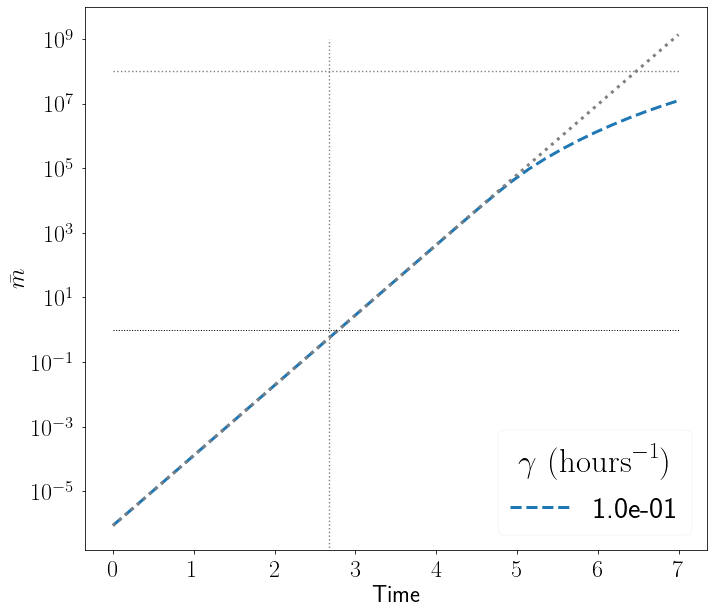

In [128]:
N_r = 1e8
print('%.1e'%N_r)
T0 = 0
Tf = 7
dT = .2
alpha = 5
alpha_lin = alpha*1e8
gamma = 1 # hour^-1
gamma = gamma*24 #days^-1
#gamma = 0.000277
q = 2
beta = 2
k_on = 1e6*24*3600;
N_c = 1e0
e_MS = -27

time = np.linspace(T0, Tf, int((Tf-T0)/dT))

antigen = 'CMFILVWYAGTSQNEDHRKPFMRTP'
antigen = 'FMLFMAVFVMTSWYC'
antigen = 'FTSENAYCGR'
antigen = 'TACNSEYPNTTK'
#antigen = 'TANSEYPNTK'
antigen = 'MRTAYRNG'

L=len(antigen)


#----------------------------------------------------------------
Tmin = .01
Tmax = 50

antigen_list = [i for i in antigen]
antigen_seq = np.array([], dtype = int)
for i, aa in enumerate(antigen_list):
    index = Alphabet_list.index(aa)
    antigen_seq = np.append(antigen_seq, int(index))
PWM_data = M2[:,antigen_seq]

#Change values by the minimum
for i in np.arange(L):
    PWM_data[:,i]-=np.min(PWM_data[:,i], axis=0)

Ts = np.linspace(Tmin, Tmax, 20000)
lambdas = 1/Ts[:-1]
F_PWM = -Ts*np.log(Z_PWM(PWM_data, Ts))
Us = F_PWM[:-1]-Ts[:-1]*(np.diff(F_PWM)/np.diff(Ts)) + e_MS
print(Us[0])
dU = np.diff(Us)
#----------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12,10), gridspec_kw={'left':0.18})
for gamma in np.array([.1])*24:
    
    Omega = 20**L
    S = np.cumsum(lambdas[:-1]*dU)
    P0 = 1/Omega
    Q0 = np.exp(S)*P0
    Q0 = np.exp(S)/np.sum(np.exp(S)*dU)
    p_a = (1/(1 + ((k_on)*np.exp(Us[:-1])/gamma)**q ) )
    p_e = ((1e3*np.exp(alpha*Tf)/N_A)*k_on)/(alpha) #probability of engagement up to time t
    Q_R = N_r*Q0*(1-np.exp(-p_e*p_a*N_c))
    psi = ((k_on*N_c)/(N_A))*p_a
    M_r = N_r*N_c*np.sum(Q0*p_a*dU)
    
    m_bar = np.array([N_r*(1-np.sum(np.exp(-(psi/alpha)*(1e3*np.exp(alpha*t)-1))*Q0*dU)) for t in time])
    m_bar_approx = ((k_on*M_r)/(N_A*alpha))*(1e3*np.exp(alpha*time))
    
    ax.plot(time, m_bar, linestyle = '--', linewidth = 3, label = '%.1e'%(gamma/24))
    ax.plot(time, m_bar_approx, color = 'grey', linestyle = ':', linewidth = 3)
    ax.vlines(time[np.where(m_bar_approx<1)[0][-1]], ax.get_ylim()[0], 1e9, color = 'grey', linestyle = ':')

ax.hlines(N_r, T0, Tf, color = 'grey', linestyle = ':')
ax.plot(time, np.ones_like(time), color = 'black', linestyle = ':', linewidth = 1)
ax.legend(title = r'$\gamma$ $(\mathrm{ hours}^{-1})$', title_fontsize = 33, fontsize=30, loc = 4)
my_plot_layout(ax = ax, yscale = 'log', xlabel = 'Time', ylabel = r'$\bar m$')
ax.set_ylim(top = N_r*100)

In [130]:
'%.1e'%(20**5)


'3.2e+06'

## Ensemble of trajectories

0.016782445427990896 0.01365902222222222 1.7266488931840787 0.55


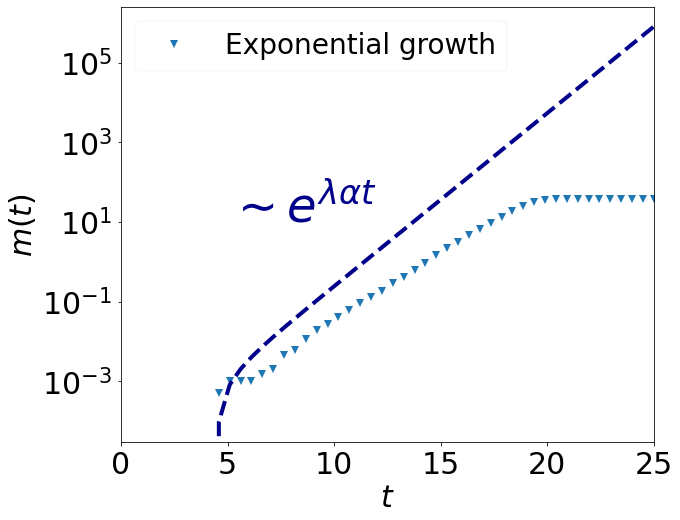

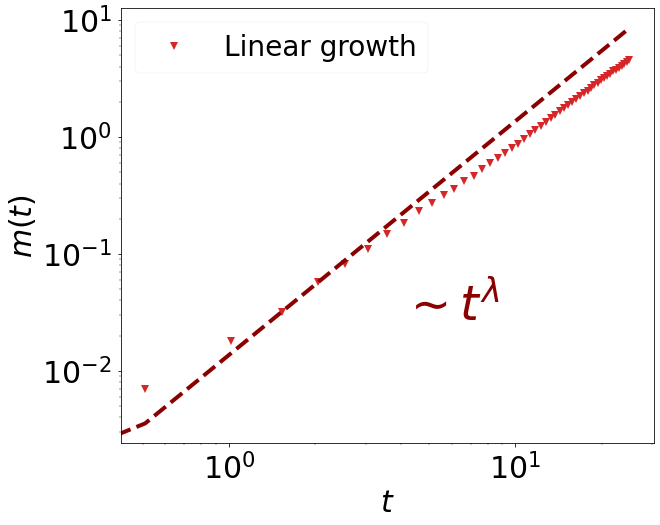

In [29]:
L = 15
NC = 1e4
T0 = 0
Tf = 25
dT = 0.5
alpha = 1
gamma = .0000
beta = 0.5

lambd = lambdas_rcs[np.where(Ns==NC)]
lambd = 0.55
energy_models = ['MJ']
ass = [0, 0]

antigen = 'FMLFMAVFVMTSWYC'

#b = 1.62
#b = 1.97
#b = 2.08
#-------------------------
growth_models = [0, 1]
models_name = ['Exponential', 'Linear']
colors = ['tab:blue','tab:red']
colors_fit = ['darkblue', 'darkred']
exponents = [-1, (-((alpha)/beta)-1)]

for ti, energy_model in enumerate(energy_models):

    fig2, ax2 = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.16})
    fig3, ax3 = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.16})

    for i, linear in enumerate(growth_models):

        time = np.linspace(T0, Tf, int((Tf-T0)/dT))
        #data_energies_ensemble = np.loadtxt(Text_files_path + 'Dynamics/Ensemble/energies_tail_ensemble_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_linear-%d.txt'%(linear))
        data_N_active_linages_ensemble = np.loadtxt(Text_files_path + 'Dynamics/Ensemble/N_active_linages_ensemble_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_alpha-%.6f_beta-%.6f_gamma-%.6f_linear-%d_'%(alpha, beta, gamma, linear)+energy_model+'.txt')

        #-------------------------

        t0 = np.where(data_N_active_linages_ensemble!=0)[0][0]*dT

        if(linear==0): #Exponential
            #lambd = 0.65
            #-------------------------------------------
            plaw_fit = ((1e-3))*(1/(alpha))*(np.exp(alpha*(time[::]-t0))-1)
            #plaw_fit = 1e-3*(np.exp(eta*lambd*(time[::]-t0)))
            ax2.plot(time[::], np.cumsum(data_N_active_linages_ensemble[::]*dT), colors[i], linestyle = '', marker = 'v', ms = 8, linewidth = 4, label = models_name[i]+" growth")
            #ax2.plot(time[::], data_N_active_linages_ensemble[::], colors[i], linestyle = '-', marker = '', ms = 8, linewidth = 4, label = models_name[i]+" growth")
            ax2.plot(time[::], plaw_fit, color = colors_fit[i], linestyle = '--', linewidth = 4)
            ax2.text(x=5e0, y=1e1, s = r'$\sim e^{\lambda \alpha t}$', fontsize=48, color = colors_fit[i])

        if(linear==1): #Linear
            a0 = 1e3
            #t0 = dT
            #lambd = 0.65
            a = np.cumsum(data_N_active_linages_ensemble[::]*dT)[3]/time[3]**(2)
            ass[ti]=a
            #-------------------------------------------
            plaw_fit = a*time[0::]**(2)
            #plaw_fit = ((1/(eta*2000*(lambd)*(eta*2000*t0+a0)**(lambd-1)))*((eta*2000*time+a0)**(lambd)-(eta*2000*t0+a0)**(lambd)))
            #plaw_fit = (2e3)**(-1)*((eta*time+a0)/(eta*t0+a0))**(lambd)
            ax3.plot(time[::], np.cumsum(data_N_active_linages_ensemble[::]*dT), colors[i], linestyle = '', marker = 'v', ms = 8, linewidth = 4, label = models_name[i]+" growth")
            
            popt, pcov = curve_fit(my_linear_func, np.log(time[1::]), np.log(np.cumsum(data_N_active_linages_ensemble[1::]*dT)))
            
            print(np.exp(popt[0]), a, popt[1], lambd)
            
            #ax3.plot(time[::], data_N_active_linages_ensemble[::], colors[i], linestyle = '-', marker = '', ms = 8, linewidth = 4, label = models_name[i]+" growth")
            ax3.plot(time[0::], plaw_fit, color = colors_fit[i], linestyle = '--', linewidth = 4)
            #ax3.plot(time, plaw_fit0, color = colors_fit[i], linestyle = '--', linewidth = 4)
            ax3.text(x=4e0, y=np.cumsum(data_N_active_linages_ensemble[::]*dT)[3]*8.5e-1, s = r'$\sim t^{\lambda}$', fontsize=48, color = colors_fit[i])

        #-------------------------
        #popt, pcov = curve_fit(my_linear_func, np.log(clone_size[5:-1]), np.log(1-cumsum_clone_size_counts[5:-1]))
        #exponent_fit = popt[1]
        #print('fit:',exponent_fit)
        #-------------------------

        #ax.plot(clone_size[:-1][2:], np.exp(my_linear_func(np.log(clone_size[:-1]), *popt))[2:], linestyle = '--', marker = '', ms = '10', linewidth = 3, color='darkred', alpha = .8)

    #-------------------------

    my_plot_layout(ax = ax2, yscale= 'log', xlabel=r'$t$', ylabel=r'$m(t)$',
                  ticks_labelsize= 30 , x_fontsize=30, y_fontsize=30 )
    ax2.set_xlim(T0, Tf)
    #ax2.set_ylim(1e-4, 1e3)
    ax2.legend(fontsize = 28)
    fig2.savefig('../Figures/1_Dynamics/Activation_rate_exp_'+energy_model+'.pdf')

    #-------------------------
    my_plot_layout(ax = ax3, xscale= 'log', yscale= 'log', xlabel=r'$t$', ylabel=r'$m(t)$',
                  ticks_labelsize= 30 , x_fontsize=30, y_fontsize=30 )
    #ax3.set_xlim(dT*10, Tf)
    #ax3.set_ylim(bottom = 0.2)
    ax3.legend(fontsize = 28)
    fig3.savefig('../Figures/1_Dynamics/Activation_rate_lin_'+energy_model+'.pdf')


n_data: 74536 74536.0
ensemble size: 963
theory: -3.0
n_data: 9108 9108.0
ensemble size: 416
theory: -1


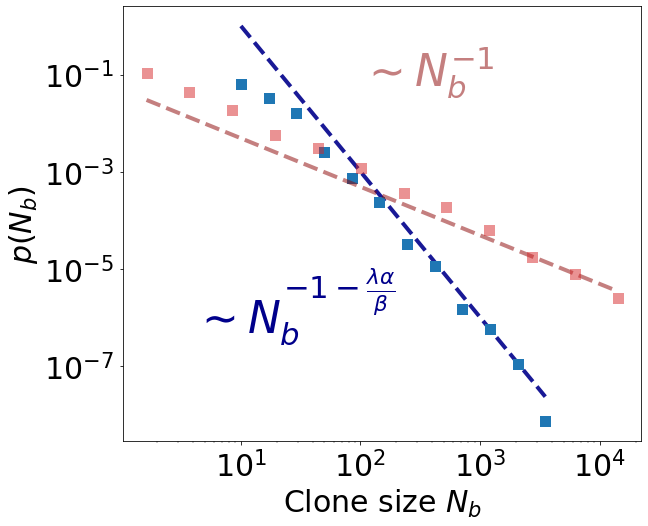

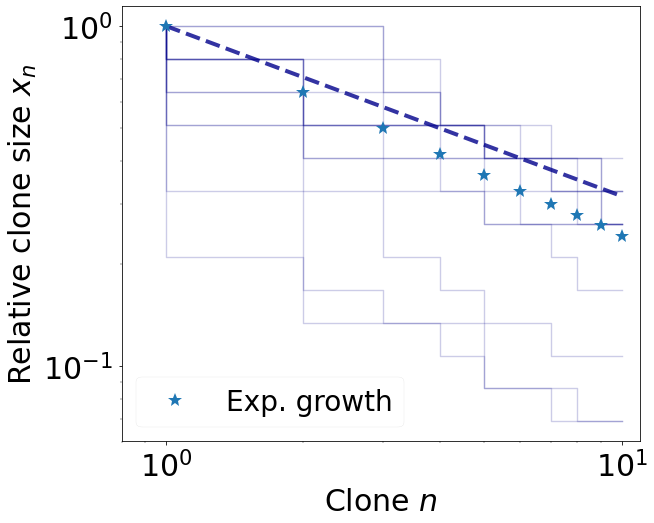

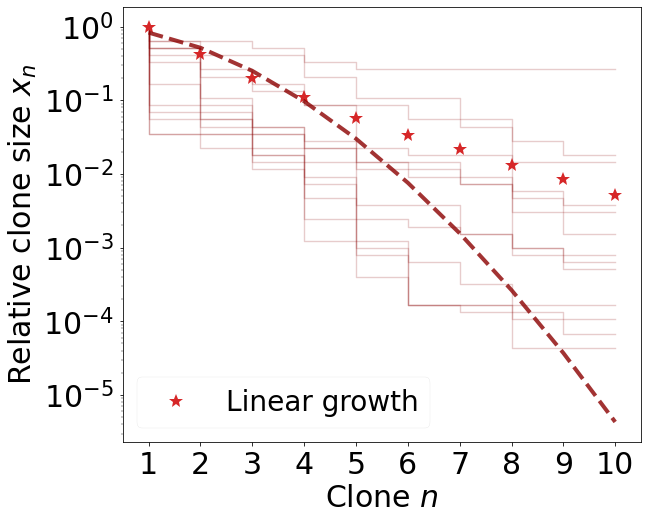

In [32]:
#
#-------------------------

for ti, energy_model in enumerate(energy_models):

    exponents = [(-((alpha)/beta)-1), -1]
    fig, ax = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18})
    fig2, ax2 = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18})
    fig3, ax3 = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18})

    for i, linear in enumerate(growth_models):

        time = np.linspace(T0, Tf, int((Tf-T0)/dT))
        data_bcells_ensemble = np.loadtxt(Text_files_path + 'Dynamics/Ensemble/bcells_ensemble_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_alpha-%.6f_beta-%.6f_gamma-%.6f_linear-%d_'%(alpha, beta, gamma, linear)+energy_model+'.txt')
        #data_energies_ensemble = np.loadtxt(Text_files_path + 'Dynamics/Ensemble/energies_tail_ensemble_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_linear-%d.txt'%(linear))
        N_final_active = np.loadtxt(Text_files_path + "Dynamics/Ensemble/N_final_active_L-%d_N-%d_Antigen-"%(L, NC)+antigen+"_alpha-%.6f_beta-%.6f_gamma-%.6f_Linear-%d_"%(alpha, beta, gamma, linear)+energy_model+".txt")

        print('n_data:',len(data_bcells_ensemble),np.sum(N_final_active))

        clone_size_distribution = np.histogram(data_bcells_ensemble, bins = np.logspace(np.log10(np.min(data_bcells_ensemble)),np.log10(np.max(data_bcells_ensemble-1)),14), density = True)

        clone_size = ((clone_size_distribution[1][:-1][np.where(clone_size_distribution[0]!=0)]+clone_size_distribution[1][1:][np.where(clone_size_distribution[0]!=0)]))/2
        clone_size_counts = clone_size_distribution[0][np.where(clone_size_distribution[0]!=0)]

        delta_clone_size = clone_size_distribution[1][1:][np.where(clone_size_distribution[0]!=0)]-clone_size_distribution[1][:-1][np.where(clone_size_distribution[0]!=0)]
        cumsum_clone_size_counts = np.cumsum(clone_size_counts*delta_clone_size)
        #-------------------------

        clone_size_array = np.logspace(np.log10(clone_size[0]), np.log10(clone_size[-2]), 100)

        N_final_active = np.concatenate(([0], N_final_active))
        N_final_active_cum = np.cumsum(N_final_active)

        if(linear==0): #Exponential
            N_clones = 10
            n_array = np.linspace(1, N_clones, N_clones)
            Clone_relative_sizes = np.zeros(N_clones)
            N_ens = 0
            for j, N_final in enumerate(N_final_active_cum[:-1]):
                if(N_final_active[j+1]>=N_clones):
                    N_ens +=1
                    temp_array = np.flip(np.sort(data_bcells_ensemble[int(N_final):int(N_final+N_final_active[j+1])]))
                    for k in range(N_clones):
                        Clone_relative_sizes[k] += (temp_array[k]/temp_array[0])
                if j%80==0:    
                    ax2.step(n_array, temp_array[:N_clones]/temp_array[0], alpha=.2, color=colors_fit[i])
            print('ensemble size:', N_ens)
            #-------------------------------------------
            plaw_fit_csd = clone_size**(exponents[i])
            plaw_fit_csd /= (plaw_fit_csd[-4]/(clone_size_counts[-4]))
            print('theory:' ,exponents[i])
            ax.text(x=4e0, y=5e-7, s = r'$\sim N_{b}^{-1-\frac{\lambda\alpha}{\beta}}$', fontsize=44, color = colors_fit[i])
            #-------------------------------------------
            ax2.plot(n_array, ((n_array))**(-beta/(alpha)), linestyle = '--', marker = '', ms = 8, linewidth = 4, color=colors_fit[i], alpha = .8)
            ax2.plot(n_array, Clone_relative_sizes/N_ens, color = colors[i], linestyle = '', linewidth = 1.5, marker = '*', ms = 15, label = 'Exp. growth')
            #ax2.text(x=1e1, y=3e-1, s = r'$\sim n^{-\frac{\beta}{\lambda\alpha}}$', fontsize=44, color = colors_fit[i])
            ax2.set_xlim(left = .8, right = N_clones+1)
            ax.plot(clone_size[:-1][:], plaw_fit_csd[:-1][:], linestyle = '--', marker = '', ms = 8, linewidth = 4, color=colors_fit[i], alpha = .9)
            ax.plot(clone_size[:-1], clone_size_counts[:-1], color = colors[i], linestyle = '', marker = 's', ms = 11, linewidth = 4)

        if(linear==1): #Linear
            N_clones = 10
            n_array = np.linspace(1, N_clones, N_clones)
            Clone_relative_sizes = np.zeros(N_clones)
            N_ens = 0
            for j, N_final in enumerate(N_final_active_cum[:-1]):
                if(N_final_active[j+1]>=N_clones):
                    N_ens +=1
                    temp_array = np.flip(np.sort(data_bcells_ensemble[int(N_final):int(N_final+N_final_active[j+1])]))
                    for k in range(N_clones):
                        Clone_relative_sizes[k] += (temp_array[k]/temp_array[0])
                if j%80==0:
                    ax3.step(n_array, temp_array[:N_clones]/temp_array[0], alpha=.2, color=colors_fit[i])
            print('ensemble size:',N_ens)
            a0 = 1e3
            t0 = dT
            #-------------------------------------------
            plaw_fit_csd = clone_size**(exponents[i])#*(np.log(clone_size**(1/beta)))**(1-lambd)
            plaw_fit_csd /= (plaw_fit_csd[-3]/(clone_size_counts[-3]))
            print('theory:' , exponents[i])
            ax.text(x=1e2, y=6e-2, s = r'$\sim N_{b}^{-1}$', fontsize=44, color = colors_fit[i], alpha = .5)
            #-------------------------------------------
            ax3.plot(n_array, Clone_relative_sizes/N_ens, color = colors[i], linestyle = '', linewidth = 1.5, marker = '*', ms = 15, label = 'Linear growth')
            ax3.plot(n_array, np.exp(-(beta)*((n_array)/(ass[ti]+1.7))**(1/lambd)), linestyle = '--', marker = '', ms = 8, linewidth = 4, color=colors_fit[i], alpha = .8)
            #ax3.text(x=6e0, y=4e-1, s = r'$\sim e^{-\beta n^{1/\lambda}}$', fontsize=44, color = colors_fit[i])
            ax3.set_xlim(left = .5, right = N_clones+.5)
            ax3.set_xticks(range(1,N_clones+1))
            ax.plot(clone_size[:-1][:], plaw_fit_csd[:-1][:], linestyle = '--', marker = '', ms = 8, linewidth = 4, color=colors_fit[i], alpha = .5)
            ax.plot(clone_size[:-1], clone_size_counts[:-1], color = colors[i], linestyle = '', marker = 's', ms = 11, linewidth = 4, alpha = .5)
        
        #-------------------------
        #popt, pcov = curve_fit(my_linear_func, np.log(clone_size[5:-1]), np.log(1-cumsum_clone_size_counts[5:-1]))
        #exponent_fit = popt[1]
        #print('fit:',exponent_fit)
        #-------------------------

        #ax.plot(clone_size[:-1][2:], np.exp(my_linear_func(np.log(clone_size[:-1]), *popt))[2:], linestyle = '--', marker = '', ms = '10', linewidth = 3, color='darkred', alpha = .8)

    #-------------------------
    my_plot_layout(ax = ax, xscale='log', yscale= 'log', xlabel=r'Clone size $N_{b}$', ylabel=r'$p(N_{b})$',
                  ticks_labelsize= 30, x_fontsize=30, y_fontsize=30 )

    my_plot_layout(ax = ax2, xscale='log', yscale= 'log', xlabel=r'Clone $n$', ylabel=r'Relative clone size $x_n$',
                  ticks_labelsize= 30, x_fontsize=30, y_fontsize=30 )
    #ax2.set_xticks(np.logspace(0,3, 20))
    ax2.legend(fontsize = 28, loc = 3)

    my_plot_layout(ax = ax3, xscale='linear', yscale= 'log', xlabel=r'Clone $n$', ylabel=r'Relative clone size $x_n$',
                  ticks_labelsize= 30, x_fontsize=30, y_fontsize=30 )
    ax3.legend(fontsize = 28, loc = 3)
    ax3.set_xticks(range(1,10+1))

    #fig.savefig('../Figures/1_Dynamics/Clone_size_distribution_'+energy_model+'.pdf')
    #fig2.savefig('../Figures/1_Dynamics/Relative_CS_1_'+energy_model+'.pdf')
    #fig3.savefig('../Figures/1_Dynamics/Relative_CS_2_'+energy_model+'.pdf')


# Deterministic Simulation

## Stochastic Simulation - Stochastic antigen dynamics

In [ ]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 0.0004
R=6
beta = 0.001
gamma = 1
T = 5
master_Sequence_energy = 0
Sub_Sequences = np.random.choice(Sequences, n_linages)
Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                              nu = nu, R = R, beta = beta, master_Sequence_energy = master_Sequence_energy)
Model.Gillespie()



## Plot linages

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(20,24))

plot_energy_matrix(Energy_Matrix=M2, Alphabet = Alphabet, title = 'MJ 1996', ax = ax[0,0])
Model.plot_antigen_time(ax = ax[0,1])
Model.plot_prob_binding(ax = ax[1,0])
Model.stackplot_linages_time(antigen = False, time = True, ax = ax[1,1])
Model.hist_sequences_hamming_distance(Sequences = Sequences, ax = ax[2,0])
Model.hist_sequences_energy(Sequences = Sequences, bins = 20, ax = ax[2,1])


counter = 0
while(os.path.isfile('../Figures/Antigen_Linages_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Antigen_Linages_%d.png'%(counter))


## entropy

In [ ]:
fig, ax = plt.subplots(4,2,figsize=(20,32))

for i, k in enumerate([4, 10, 50, 100]):

    biggest_k_linages_freq = Model.plot_k_largest_linages(k=k, ax=ax[i,0])
    Model.plot_entropy_k_largest_linages(k=k, biggest_k_linages_freq = biggest_k_linages_freq, ax=ax[i,1])

counter = 0
while(os.path.isfile('../Figures/Entropy_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Entropy_%d.png'%(counter))


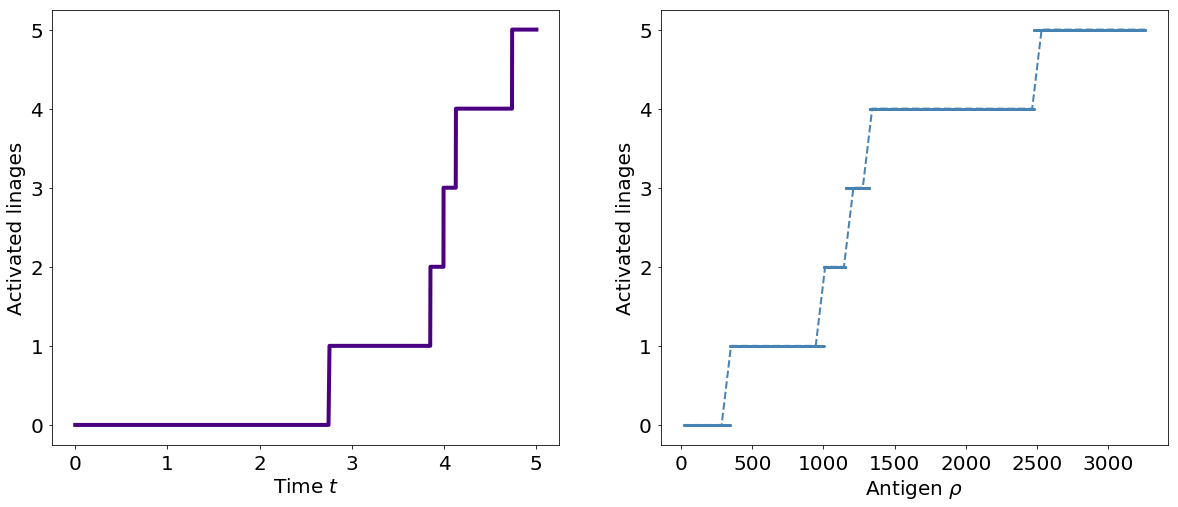

In [28]:
activation_time_series = [np.sum(Model.activation_time_series[:,i]) for i in range(int(len(Model.activation_time_series[0,:])))]
f = interp1d(Model.antigen_time_series, activation_time_series)
x_new = np.linspace(20, np.max(Model.antigen_time_series), 50)

fig, ax = plt.subplots(1,2,figsize=(20,8))

ax[0].plot(Model.time_series, activation_time_series, linewidth = 4, color = 'indigo')
ax[0].set_xlabel(r'Time $t$', fontsize = 20)
ax[0].set_ylabel(r'Activated linages', fontsize = 20)
ax[0].tick_params(labelsize = 20)
#ax[0].set_yscale('log')
#ax[0].legend(loc = 0, fontsize = 20)

ax[1].plot(Model.antigen_time_series, activation_time_series, '.', ms = 5, linewidth = 4, color = 'steelblue')
ax[1].plot(x_new, f(x_new), '--', linewidth = 2, color = 'steelblue')
ax[1].set_xlabel(r'Antigen $\rho$', fontsize = 20)
ax[1].set_ylabel(r'Activated linages', fontsize = 20)
ax[1].tick_params(labelsize = 20)
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
#ax[1].legend(loc = 0, fontsize = 20)



In [1]:
a = 4

In [64]:
antigen = 1e8/N_A
display(Math(r'\textrm{Antigen concentration = }%.2e M'%(antigen)))
k_D = np.exp(Sequences[10].energy)
display(Math(r'\epsilon=%.3f'%(Sequences[10].energy)))
display(Math((r'$k_D=%.2e$'%(k_D))))
display(Math(r'f=%.6f'%(antigen/(antigen+k_D))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [15]:
Model.antigen_time_series[0,0:2]

array([1., 1.])

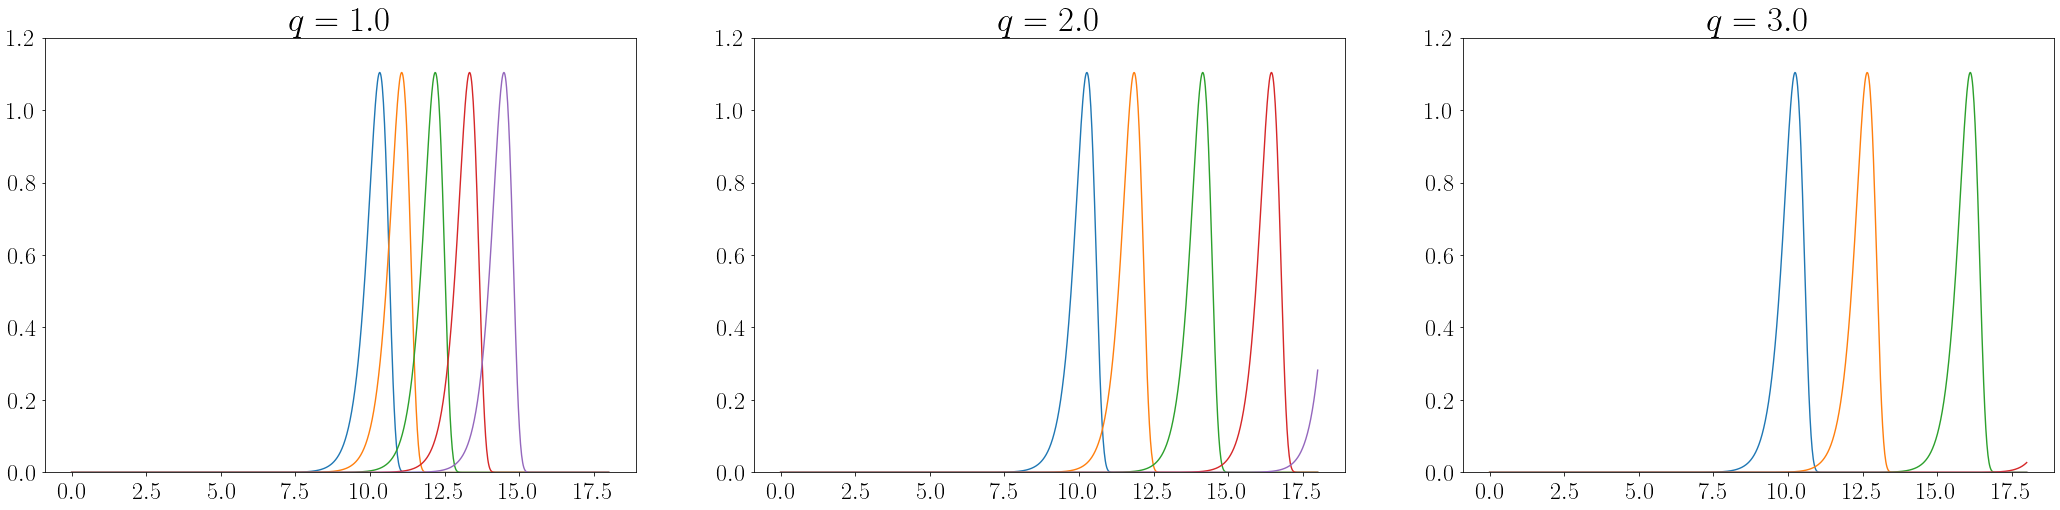

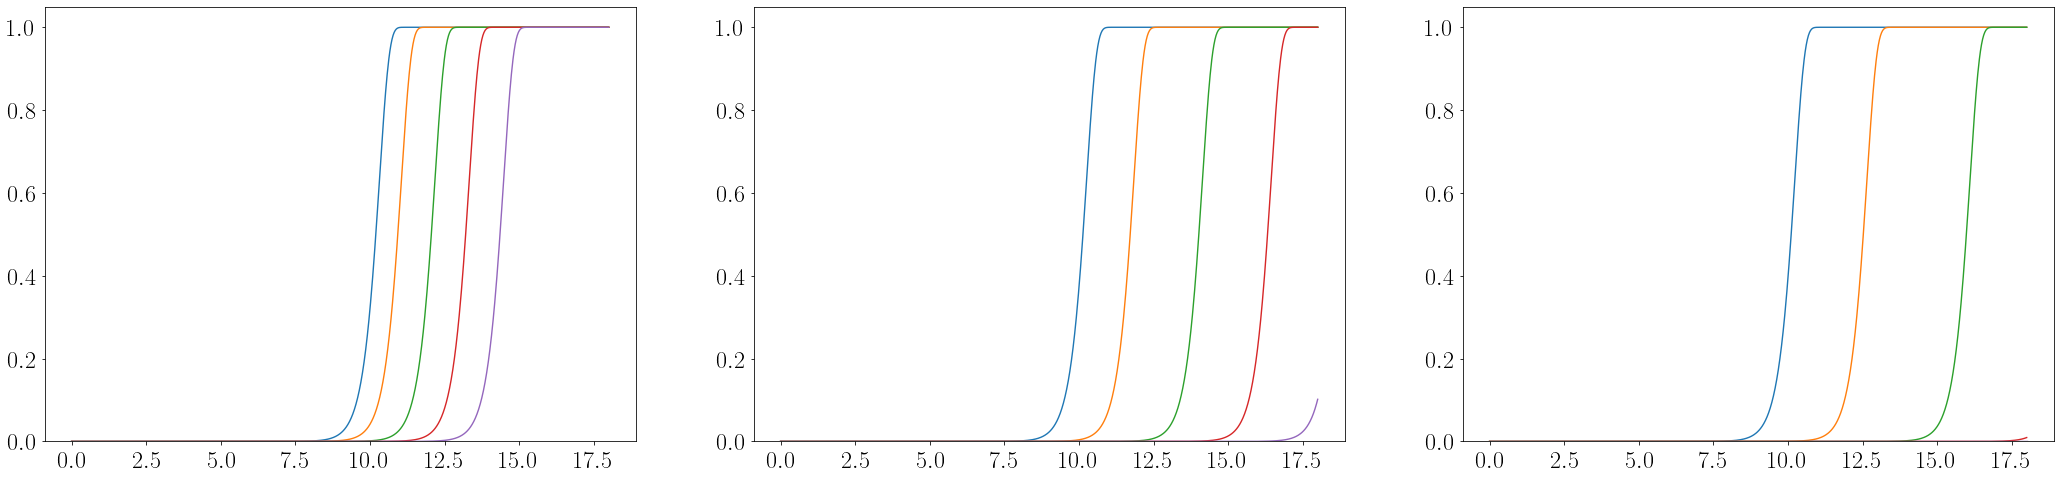

In [81]:
time = np.linspace(0, 18, 1000)
alpha = 3 # day^-1
k_on = 1e6 #(M*s)^-1
k_on = k_on*24*3600 #(M*day)^-1
gamma = 1/3600 # s^-1
gamma = gamma*24*3600
k_offs = np.logspace(-4, 2, 5) # s^-1
k_offs = k_offs*24*3600 # day^-1
#rho_A = ((1e13*np.exp(alpha*time))/(1e13+(np.exp(alpha*time)-1)))/N_A # Logistic growth
rho_A = np.exp(alpha*time)/N_A
qs = np.arange(1, 4)
fig, ax = plt.subplots(1, 3, figsize = (36, 8))
for i, q in enumerate(qs):
    for j, k_off in enumerate(k_offs):
        prob = ((rho_A*k_on)/(1+(k_off/gamma)**q)) * np.exp(-((rho_A*k_on/alpha)/(1+(k_off/gamma)**q)))
        ax[i].plot(time, prob)
    my_plot_layout(ax=ax[i], yscale = 'linear')
    ax[i].set_ylim(bottom = 1e-20, top=1.2)
    ax[i].set_title(r'$q=%.1f$'%q, fontsize = 35)
    
fig, ax = plt.subplots(1, 3, figsize = (36, 8))
dt = time[1]-time[0]
for i, q in enumerate(qs):
    for j, k_off in enumerate(k_offs):
        prob = ((rho_A*k_on)/(1+(k_off/gamma)**q)) * np.exp(-((rho_A*k_on/alpha)/(1+(k_off/gamma)**q)))*dt
        cum_prob = np.cumsum(prob)
        ax[i].plot(time, cum_prob)
    my_plot_layout(ax=ax[i], yscale = 'linear')
    ax[i].set_ylim(bottom = 1e-20)


In [74]:
%%time
k_off = 1e-8
prob = ((rho_A*k_on)/(1+(k_off/gamma)**q)) * np.exp(-((rho_A*k_on/alpha)/(1+(k_off/gamma)**q)))
cum_prob = np.cumsum(prob*dt)
activation_times = np.searchsorted(cum_prob, np.random.random(10000000))*dt


CPU times: user 794 ms, sys: 62.5 ms, total: 856 ms
Wall time: 862 ms


In [77]:
np.exp(2*9)

65659969.13733051